In [1]:
import anndata as ad
from collections import Counter
import numpy as np
import scipy.stats as st
import re
import matplotlib.pyplot as plt

import sys
sys.path.append(r'C:\Users\dap182\Documents\Stallaert_lab\PDAC_pipeline')

from cc_mapping.params.optimal_palantir_pseudotime_params import cell_line_optimal_palantir_dict 
from cc_mapping.params.optimal_phate_params import cell_line_optimal_phate_dict 
from cc_mapping import preprocess_v2
#from cc_mapping import manifold
from cc_mapping import core
from cc_mapping.utils import get_str_idx
#from cc_mapping.pseudotime import plot_palantir_pseudotime
from cc_mapping.create_instructions import Create_Instructions

In [2]:

cell_line = 'CFPAC'
main_dir = "C:/Users/dap182/Documents/Stallaert_lab/PDAC_pipeline"
#main_dir = r"R:\Dante\git\PDAC_pipeline"
data_dir = f'{main_dir}/data'
fig_dir = f'{main_dir}/figures'
data_file = f'{data_dir}/{cell_line}/{cell_line}.h5ad'

adata = ad.read_h5ad(data_file)
adata.obs['CellID'] = adata.obs.index
adata.uns['cell_line'] = cell_line
adata.var_names = adata.var['X_features']

In [3]:
fs_method = 'RF_min_max'
fs_name = 'RF_min_max_feature_set'
fs_criteria = 'all_cells'
data_criteria = 'diploid'

## Random Forest Feature Selection

In [33]:
training_features =  [feat for feat in adata.var.X_features if re.search('((Std_PCNA|Intg_DNA|over_|Med_).*(nuc))|((AreaShape_Area).*(nuc|cell))', feat) != None]
adata = core.random_forest_feature_selection(adata, training_features, training_labels = 'phase', method = fs_method)

adata = preprocess_v2.row_data_partitioning(adata, search_str = data_criteria, search_obs = 'genome')

UnboundLocalError: local variable 'feat_idx_names' referenced before assignment

## PHATE 

In [5]:
#phate_optimal_parameter_dict = {'t': 25 , 'gamma': -0.5 , 'knn': 50 }
phate_optimal_parameter_dict = cell_line_optimal_phate_dict[fs_method][fs_criteria][cell_line]

adata = manifold.run_phate(adata, 
                           feature_set = 'RF_min_max_feature_set', 
                           phate_param_dict = phate_optimal_parameter_dict,
                           norm_method = 'z_score',)

Calculating PHATE...
  Running PHATE on 24219 observations and 9 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...


    Calculated KNN search in 9.60 seconds.
    Calculating affinities...
    Calculated affinities in 0.89 seconds.
  Calculated graph and diffusion operator in 10.63 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 6.32 seconds.
    Calculating KMeans...
    Calculated KMeans in 4.35 seconds.
  Calculated landmark operator in 11.94 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.56 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.45 seconds.
Calculated PHATE in 26.59 seconds.


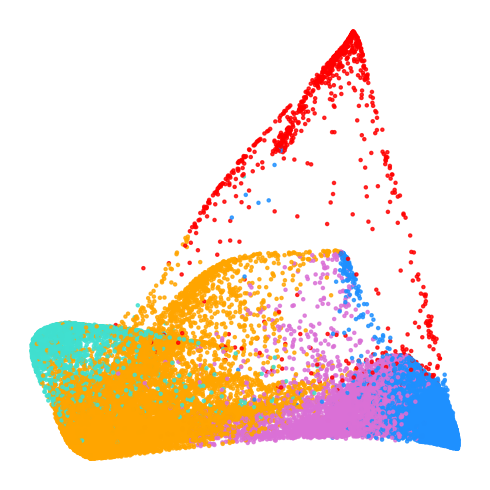

In [6]:
fig = plt.figure(figsize=(5,5))
plt.scatter(adata.obsm['X_phate'][:,0], adata.obsm['X_phate'][:,1], c = adata.obs['phase_colors'], s=5, alpha=0.8, rasterized=True)

plt.axis('off')
plt.tight_layout()

In [7]:
adata.write(f'{data_dir}/{cell_line}/{cell_line}.h5ad')

## Find root cell indexs

C:\Users\dap182\AppData\Local\Temp\ipykernel_35624\4275839018.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('rainbow', len(root_cell_idxs))


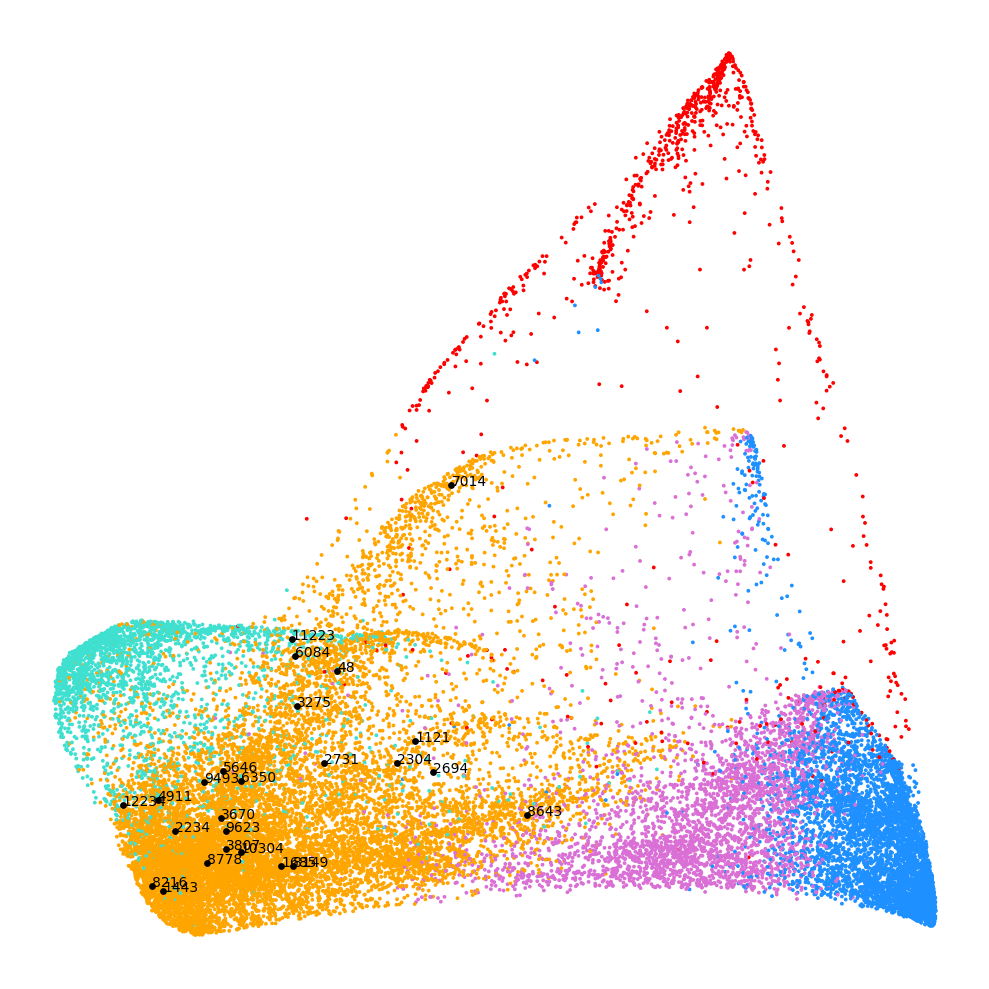

In [10]:
from cc_mapping.general_utils import determine_pseudotime_root_cell_idxs, row_data_partitioning

palantir_dict =  {'norm': 'norm',
                  'root_cell_criteria': ['proliferative'],
                  'num_root_cells': 25,
                  'phase_set':'3GS',}

phase_set_cell_df = row_data_partitioning(adata, palantir_dict['phase_set'])

palantir_root_cell_criteria = palantir_dict['root_cell_criteria']
palantir_num_root_cells = palantir_dict['num_root_cells']
root_cell_idxs = determine_pseudotime_root_cell_idxs(phase_set_cell_df,palantir_root_cell_criteria,palantir_num_root_cells)

fig = plt.figure(figsize=(10,10))

x = adata.obsm['X_phate'][:,0]
y = adata.obsm['X_phate'][:,1]
color = adata.obs['phase_colors']

plt.scatter(x,y, c=color, s=3)

patch_list = []
cmap = plt.cm.get_cmap('rainbow', len(root_cell_idxs))

color = [cmap(idx) for idx in range(len(root_cell_idxs))]
x = phase_set_cell_df.obsm['X_phate'][:,0]
y = phase_set_cell_df.obsm['X_phate'][:,1]

#root_cell_idxs = ['2383','1280','14','585','1443','3103','569']
#root_cell_idxs = [2383,1280,14,585,1443,3103,569]

x = x[root_cell_idxs]
y = y[root_cell_idxs]

plt.scatter(x,y,color = 'black', s=15)
#plt.scatter(x,y, c=color, s=15)
for idx,root_cell in enumerate(root_cell_idxs):
    plt.annotate(root_cell,(x[idx],y[idx]), fontsize=10)
plt.axis('off')
plt.tight_layout()
#print(root_cell_idxs)

## Palantir Pseudotime

In [10]:
import palantir  

ps_adata = preprocess.row_data_partitioning(adata, '3GS')

#print(np.sum(ps_adata.X,axis=0))
#ps_adata.X = st.zscore(ps_adata.X, axis=0)
#print(np.sum(ps_adata.X,axis=0))

ps_adata = preprocess.isolate_feature_set(ps_adata, load_phate_options_dict)
#print(np.sum(ps_adata.X,axis=0))


optimal_palantir_parameter_dict = {'n_components':20, 'num_waypoints':1000, 'knn': 30}


findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [4]:
phase_set = '3GS'
root_cell = '3670'
PaPSN = 'p1'
optimal_palantir_parameter_dict = cell_line_optimal_palantir_dict[PaPSN][fs_method][fs_criteria][data_criteria][phase_set][cell_line][root_cell]

In [5]:
adata

AnnData object with n_obs × n_vars = 33550 × 568
    obs: 'WellID', 'condition', 'state', 'DNA_content', 'phase', 'phase_colors', 'genome', 'cell_line', 'CellID'
    var: 'X_features'
    uns: 'dpt_pseudotimes', 'feature_sets', 'wayne_PHATE_2D', 'wayne_PHATE_3D', 'cell_line'

In [6]:
if phase_set == '3GS':
    phase_set_list = ['G0', 'G1', 'S', 'G2']

adata = preprocess_v2.row_data_partitioning(adata, search_str = data_criteria, search_obs = 'genome')
training_features =  [feat for feat in adata.var.X_features if re.search('((Std_PCNA|Intg_DNA|over_|Med_).*(nuc))|((AreaShape_Area).*(nuc|cell))', feat) != None]
adata = core.random_forest_feature_selection(adata, training_features, training_labels = 'phase', method = fs_method)
ps_adata = preprocess_v2.row_data_partitioning(adata, search_str = phase_set_list, search_obs = 'phase')

In [7]:
fs_bool = ps_adata.var[fs_name].values
ps_adata.X = st.zscore(ps_adata.X, axis=0)

ps_adata.obsm[f'X_palantir'] = ps_adata.X[:,ps_adata.var[fs_name]]
#ps_adata.obsm['X_palantir'] = st.zscore(ps_adata.X,axis=0)
#ps_adata.obsm['X_palantir'] = ps_adata.obsm['X_palantir'][:,fs_bool]

In [8]:
import palantir 

data_key = 'X_palantir'

n_components = optimal_palantir_parameter_dict['NC']
num_waypoints = optimal_palantir_parameter_dict['NW']
knn = optimal_palantir_parameter_dict['knn']

palantir.utils.run_diffusion_maps(ps_adata, n_components=n_components, pca_key=data_key ,seed=0)
palantir.utils.determine_multiscale_space(ps_adata)

palantir.core.run_palantir(ps_adata, root_cell, num_waypoints=num_waypoints, knn=knn,seed=0)


findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


Determing nearest neighbor graph...
Sampling and flocking waypoints...
Time for determining waypoints: 0.03617494106292725 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.4337934136390686 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9974
Correlation at iteration 2: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [9]:
palantir.plot.plot_palantir_results(ps_adata, embedding_basis='X_phate')

KeyError: "'X_phate' not found in .obsm."

findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

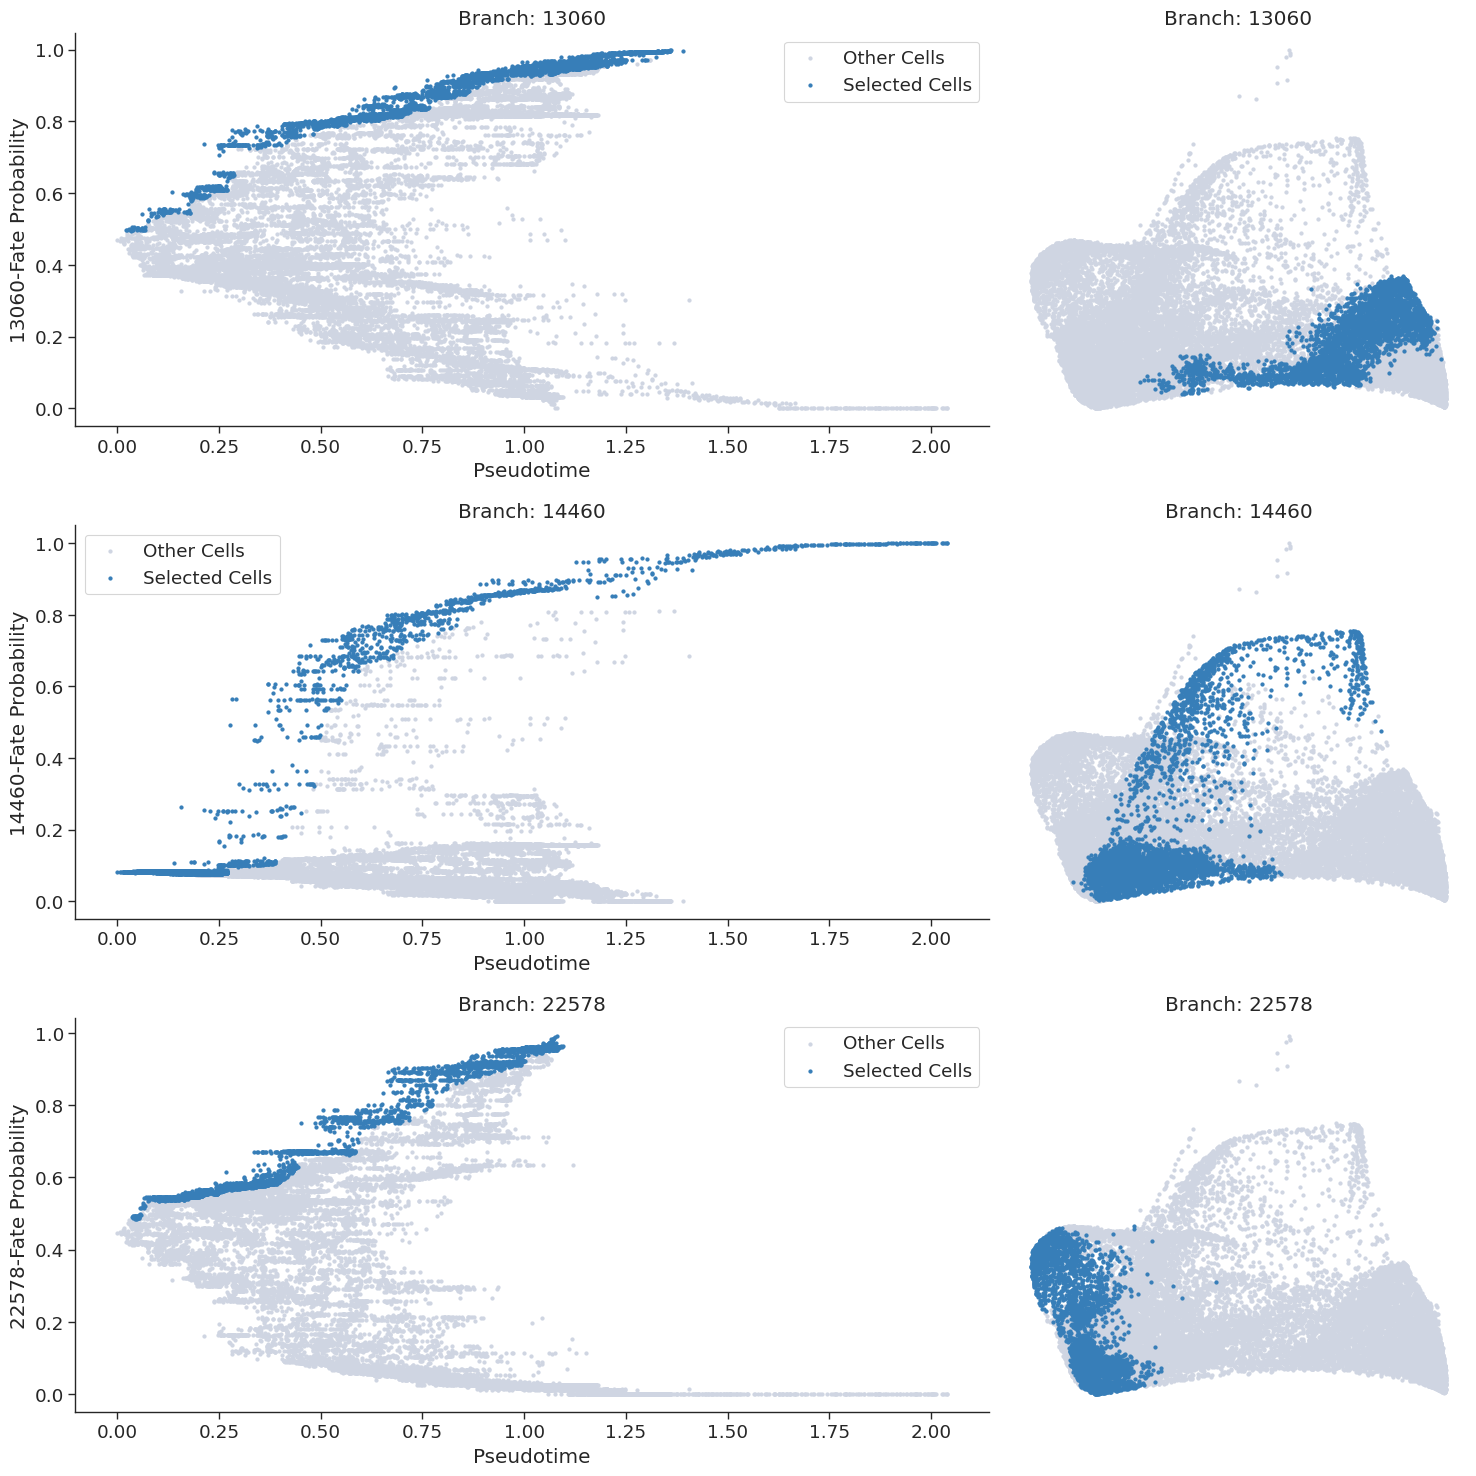

findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

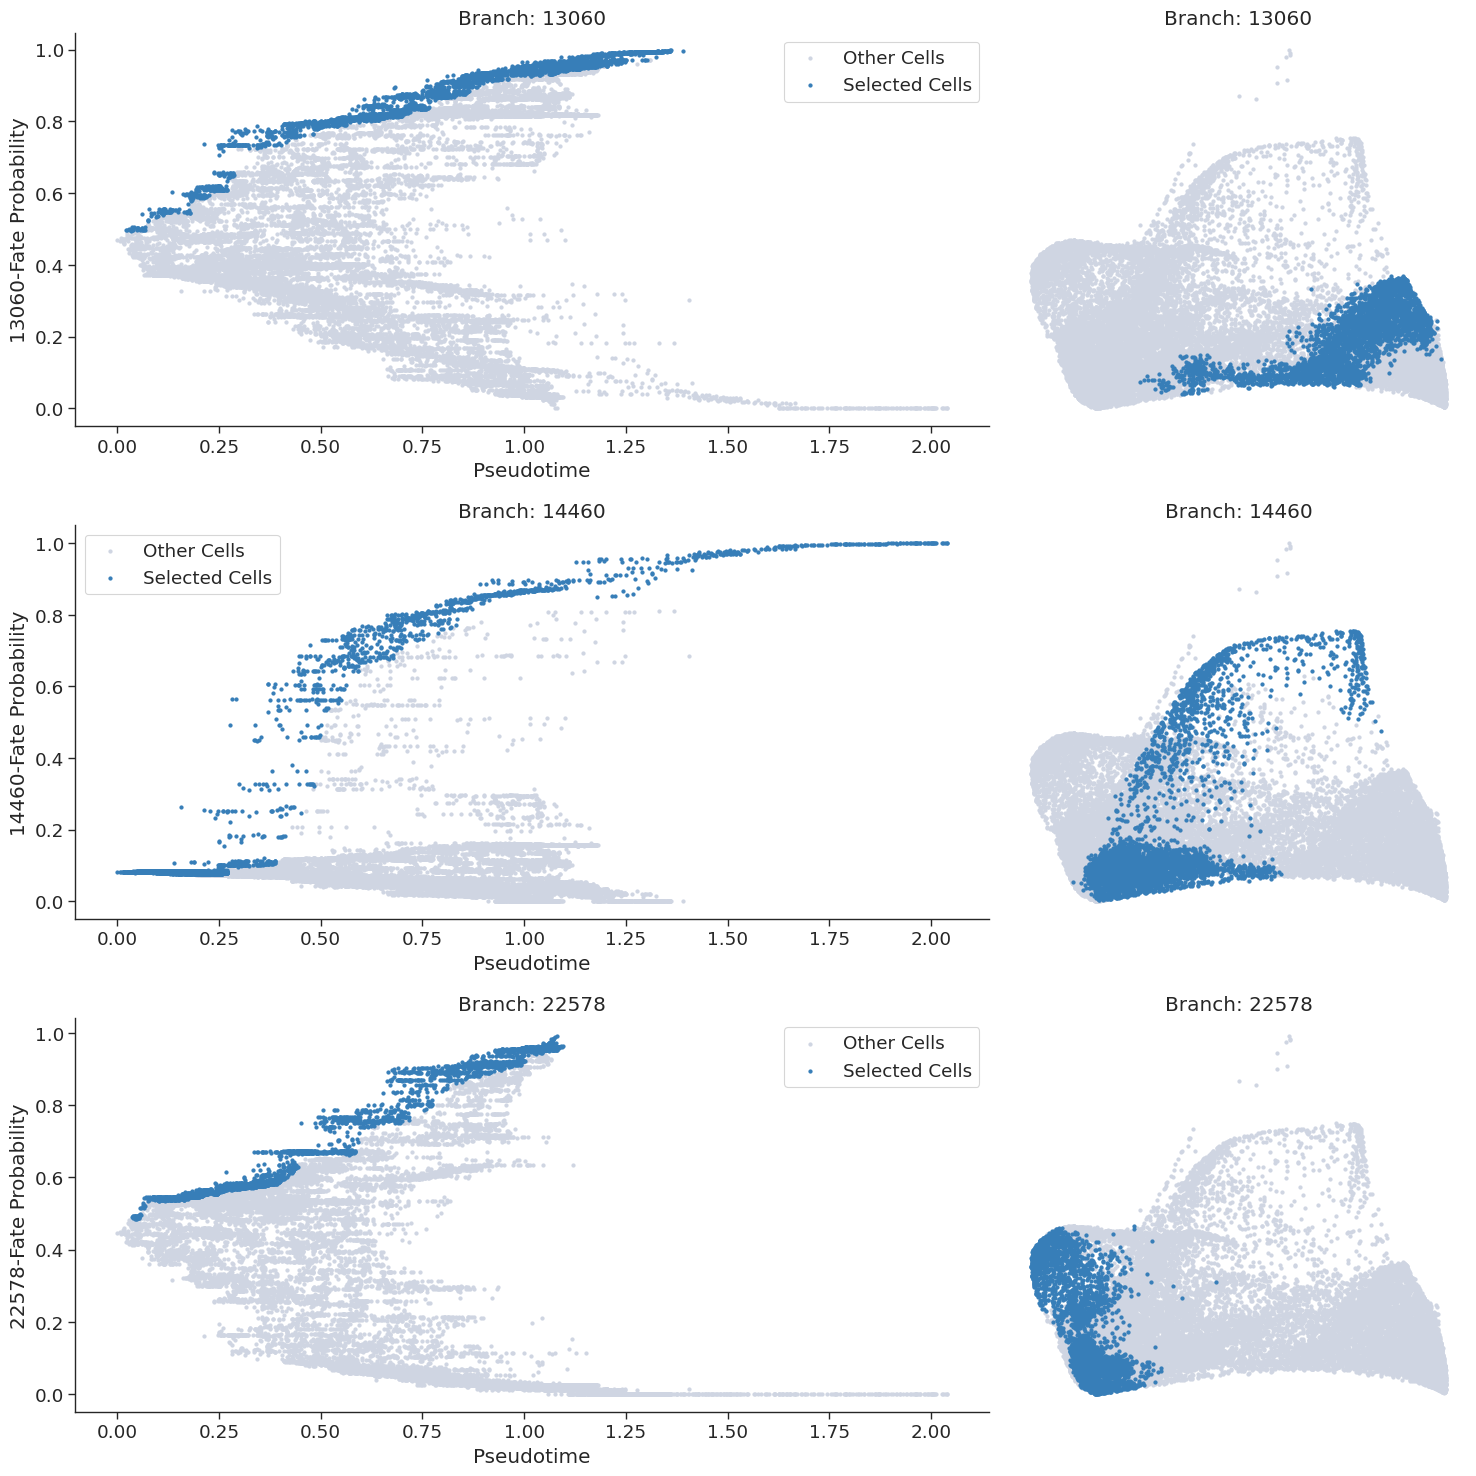

In [52]:
masks = palantir.presults.select_branch_cells(ps_adata)
palantir.plot.plot_branch_selection(ps_adata, embedding_basis='X_phate',s=5)

In [53]:
ps_adata.obsm['branch_masks'].columns = ['Main Proliferative', 'Alternative Proliferative', 'Arrest']
ps_adata.var_names = ps_adata.var['X_features']

palantir.presults.compute_gene_trends(ps_adata)

Main Proliferative
[2023-10-18 12:17:30,594] [INFO    ] Using covariance function Matern52(ls=10.0).
Alternative Proliferative
[2023-10-18 12:17:31,548] [INFO    ] Using covariance function Matern52(ls=10.0).
Arrest
[2023-10-18 12:17:33,145] [INFO    ] Using covariance function Matern52(ls=10.0).


{'Main Proliferative': {'trends':                          0.022922  0.025661  0.028399  0.031137  0.033876  \
  X_features                                                                  
  AreaShape_Area_cell      0.421932  0.416547  0.411226  0.405968  0.400774   
  AreaShape_Area_nuc       0.818528  0.805841  0.793338  0.781018  0.768882   
  AreaShape_Center_X_cell  0.100750  0.097745  0.094750  0.091764  0.088788   
  AreaShape_Center_X_nuc   0.101444  0.098417  0.095401  0.092394  0.089397   
  AreaShape_Center_Y_cell  0.086284  0.082960  0.079679  0.076442  0.073249   
  ...                           ...       ...       ...       ...       ...   
  Int_pp27_over_p27_ring  -0.037976 -0.039260 -0.040521 -0.041759 -0.042973   
  Int_pp65_over_p65_cyto  -0.046880 -0.046872 -0.046872 -0.046879 -0.046895   
  Int_pp65_over_p65_nuc   -0.131152 -0.129337 -0.127547 -0.125784 -0.124048   
  Int_pp65_over_p65_ring  -0.093124 -0.091931 -0.090760 -0.089613 -0.088488   
  MYC_over_p27      

In [46]:
branch = 'Main Proliferative'

branches = ['Main Proliferative', 'Alternative Proliferative', 'Arrest']
for b in branches:
    cols = ps_adata.varm[f'gene_trends_{b}'].columns.astype(np.float64)
    ps_adata.varm[f'gene_trends_{b}'].columns = cols/np.max(cols)

In [47]:
import re
def get_str_idx(str_to_find, string_list, regex=True):
    
    if type(str_to_find) == str:
        feat_idx_names = np.array([[idx,string_list[idx]] for idx, string in enumerate(string_list) if re.search(str_to_find, string) != None])

    elif type(str_to_find) == list:

        match_list = []
        for re_string in str_to_find:
            feat_idx_names = [[idx,string_list[idx]] for idx, string in enumerate(string_list) if re.search(re_string, string) != None]
            if feat_idx_names != []:
                match_list.append(feat_idx_names)

        feat_idx_names = np.vstack(match_list)
        
    return feat_idx_names[:,0].astype(int), feat_idx_names[:,1]

In [16]:
import argparse

class Args(argparse.Namespace):
    pass

args = Args()
for key, value in load_phate_options_dict.items():
    setattr(args, key, value)

args.cell_line = adata.uns['cell_line']

optim_feature_set = adata.uns['feature_sets'][f'optimal_{args.cell_line}_{args.fs}_{args.fs_criterion_key}_feature_list'].tolist()

feat_idxs, _ = get_str_idx(optim_feature_set, adata.var.X_features)
gene_idxs = [str(feat) for feat in feat_idxs]

In [18]:
OldFS_idxs, OldFS_names = get_str_idx('((Std_PCNA|Intg_DNA|_over|Med_).*(nuc))|((AreaShape_Area).*(nuc|cell))', adata.var.X_features)

OldFS_pseudotime_df = adata[:,OldFS_idxs].copy()

to_drop_idxs, to_drop_names = get_str_idx("(AKT|pBcl2|EGFR|pERK|FOX|GSK|IGF1R|MEK|Msi2|RSK|SMAD|STAT|YAP|PARP|TOR|p65|_Plk1)", OldFS_pseudotime_df.var.X_features)

true_bool_array = np.repeat(True, OldFS_pseudotime_df.shape[1])
true_bool_array[to_drop_idxs] = False
feature_pseudotime_df = OldFS_pseudotime_df[:,true_bool_array].copy()

genes = feature_pseudotime_df.var.X_features.values

findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

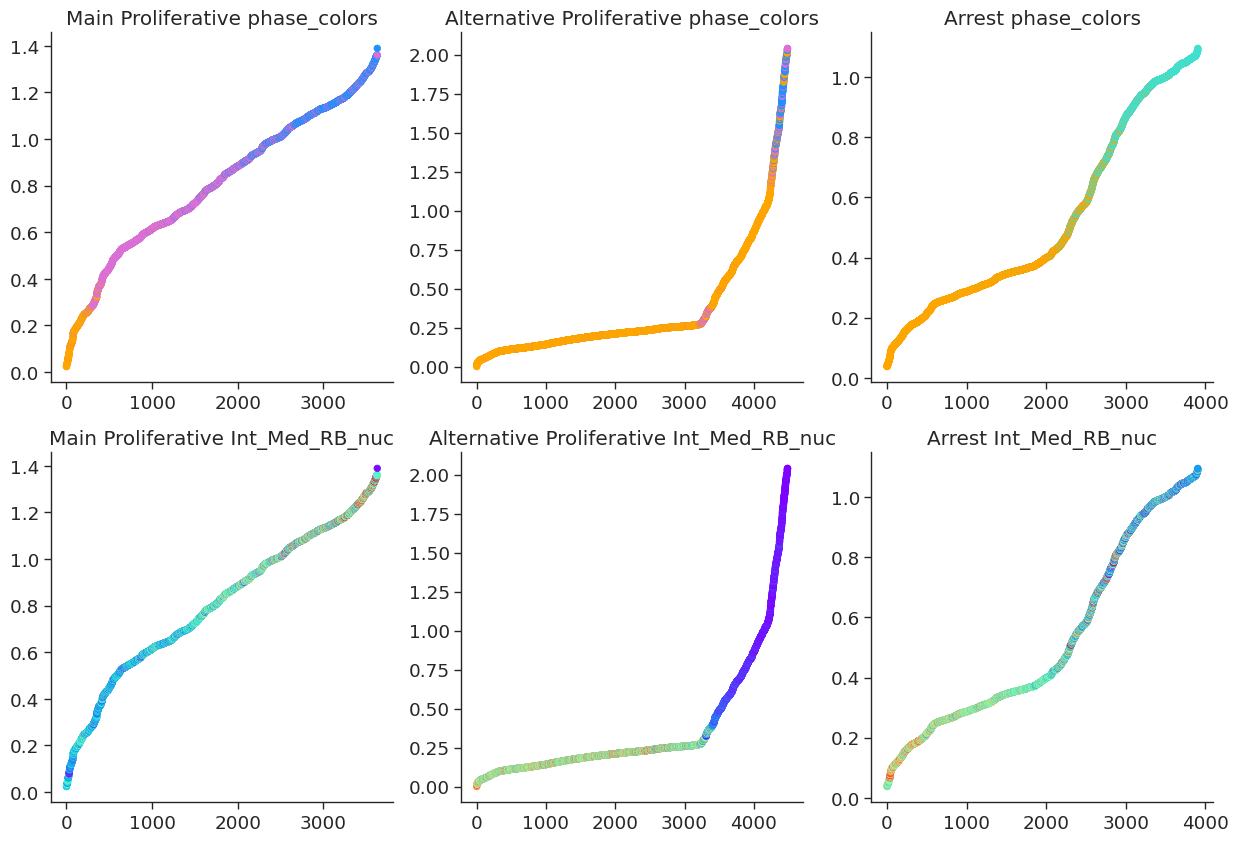

In [73]:
from cc_mapping.project_utils import get_legend
from cc_mapping.general_utils import get_str_idx

fate_probs = ps_adata.obsm['palantir_fate_probabilities'].values
branch_names = ps_adata.obsm['branch_masks'].columns

branch_assignments = np.argmax(fate_probs,axis=1)
branch_assignments = [branch_names[idx] for idx in branch_assignments]

colors = ['phase_colors','Int_Med_RB_nuc']
num_branches = len(ps_adata.obsm['branch_masks'].columns)
unit_size = 5
fig, ax = plt.subplots(len(colors),num_branches,figsize=(num_branches*unit_size,10))

for i in range(num_branches):
    branch_idxs = np.argwhere(ps_adata.obsm['branch_masks'].iloc[:,i].values == True).squeeze()
    branch_df = ps_adata[branch_idxs,:]
    branch_pseudotime = branch_df.obs['palantir_pseudotime'].values
    sorted_branch_pseudotime_idxs = np.argsort(branch_pseudotime)
    sorted_branch_pseudotime = branch_pseudotime[sorted_branch_pseudotime_idxs]

    x = np.arange(len(branch_pseudotime))
    for j in range(len(colors)):
        color_name = colors[j]
        try:
            color = list(branch_df.obs[color_name].values[sorted_branch_pseudotime_idxs])
            ax[j,i].scatter(x, sorted_branch_pseudotime, c=color, linewidth=0.5)
        except:
            color_idxs, _ = get_str_idx(color_name, branch_df.var_names)
            vmin = np.percentile(branch_df.X[:,color_idxs].toarray().squeeze(), 1)
            vmax = np.percentile(branch_df.X[:,color_idxs].toarray().squeeze(), 99)
            color = branch_df.X[:,color_idxs].toarray().squeeze()[sorted_branch_pseudotime_idxs]
            ax[j,i].scatter(x, sorted_branch_pseudotime, c=color,cmap='rainbow', linewidth=0.5,vmin=vmin,vmax=vmax)

        ax[j,i].set_title(ps_adata.obsm['branch_masks'].columns[i]+' '+color_name )
        #patches = get_legend(ps_adata, color_name)
        #plt.legend(handles=patches)

        

findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

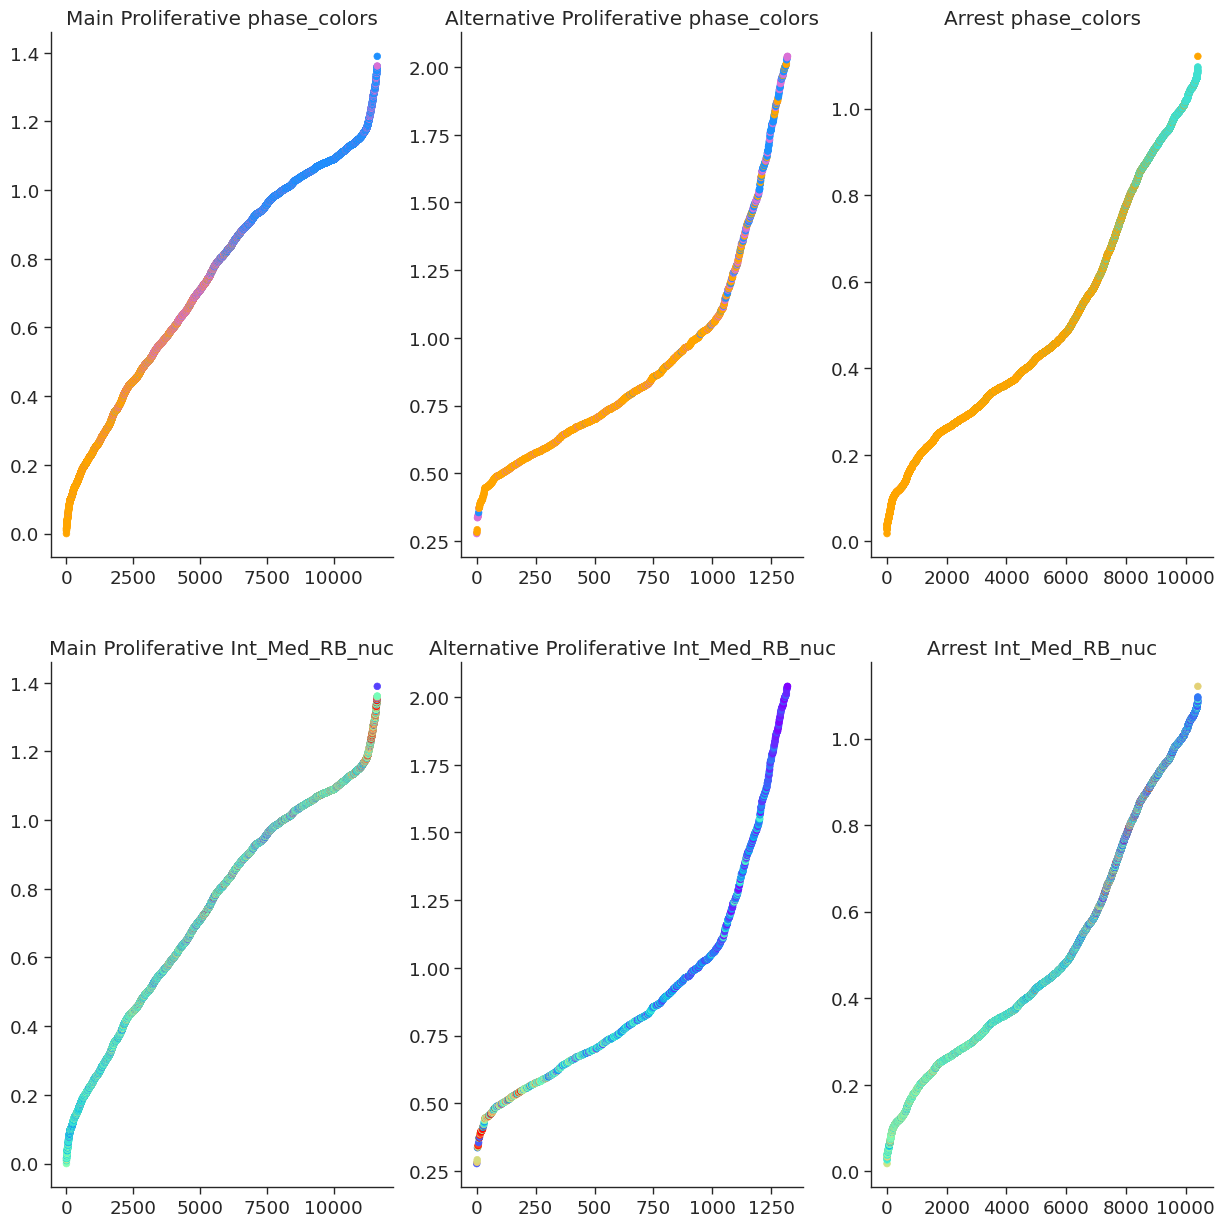

In [71]:
from cc_mapping.project_utils import get_legend
from cc_mapping.general_utils import get_str_idx

fate_probs = ps_adata.obsm['palantir_fate_probabilities'].values
branch_names = ps_adata.obsm['branch_masks'].columns

branch_assignments = np.argmax(fate_probs,axis=1)
branch_assignments = [branch_names[idx] for idx in branch_assignments]

colors = ['phase_colors','Int_Med_RB_nuc']
num_branches = len(ps_adata.obsm['branch_masks'].columns)
unit_size = 5
fig, ax = plt.subplots(len(colors),num_branches,figsize=(num_branches*unit_size,15))

for i in range(num_branches):
    branch_name = branch_names[i]
    branch_idxs, _ = get_str_idx(branch_name, branch_assignments)
    branch_df = ps_adata[branch_idxs,:]
    branch_pseudotime = branch_df.obs['palantir_pseudotime'].values
    sorted_branch_pseudotime_idxs = np.argsort(branch_pseudotime)
    sorted_branch_pseudotime = branch_pseudotime[sorted_branch_pseudotime_idxs]

    x = np.arange(len(branch_pseudotime))
    for j in range(len(colors)):
        color_name = colors[j]
        try:
            color = list(branch_df.obs[color_name].values[sorted_branch_pseudotime_idxs])
            ax[j,i].scatter(x, sorted_branch_pseudotime, c=color, linewidth=0.5)
        except:
            color_idxs, _ = get_str_idx(color_name, branch_df.var_names)
            vmin = np.percentile(branch_df.X[:,color_idxs].toarray().squeeze(), 1)
            vmax = np.percentile(branch_df.X[:,color_idxs].toarray().squeeze(), 99)
            color = branch_df.X[:,color_idxs].toarray().squeeze()[sorted_branch_pseudotime_idxs]
            ax[j,i].scatter(x, sorted_branch_pseudotime, c=color,cmap='rainbow', linewidth=0.5,vmin=vmin,vmax=vmax)

        ax[j,i].set_title(ps_adata.obsm['branch_masks'].columns[i]+' '+color_name )
        #patches = get_legend(ps_adata, color_name)
        #plt.legend(handles=patches)

        

['Main Proliferative',
 'Arrest',
 'Arrest',
 'Main Proliferative',
 'Main Proliferative',
 'Main Proliferative',
 'Main Proliferative',
 'Main Proliferative',
 'Main Proliferative',
 'Arrest',
 'Arrest',
 'Main Proliferative',
 'Main Proliferative',
 'Main Proliferative',
 'Main Proliferative',
 'Arrest',
 'Main Proliferative',
 'Arrest',
 'Arrest',
 'Main Proliferative',
 'Main Proliferative',
 'Main Proliferative',
 'Arrest',
 'Arrest',
 'Arrest',
 'Arrest',
 'Main Proliferative',
 'Arrest',
 'Arrest',
 'Main Proliferative',
 'Arrest',
 'Main Proliferative',
 'Arrest',
 'Main Proliferative',
 'Main Proliferative',
 'Main Proliferative',
 'Arrest',
 'Main Proliferative',
 'Arrest',
 'Arrest',
 'Main Proliferative',
 'Main Proliferative',
 'Arrest',
 'Main Proliferative',
 'Arrest',
 'Main Proliferative',
 'Main Proliferative',
 'Main Proliferative',
 'Arrest',
 'Arrest',
 'Main Proliferative',
 'Main Proliferative',
 'Arrest',
 'Arrest',
 'Main Proliferative',
 'Arrest',
 'Main Proli

findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

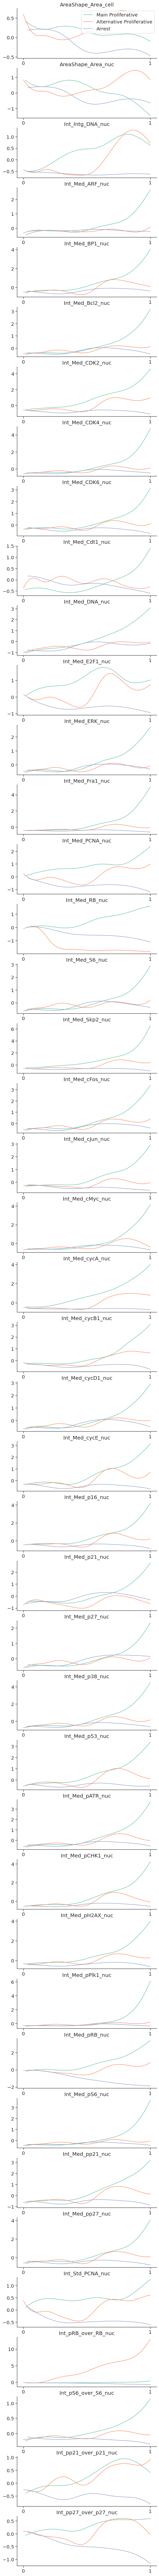

findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

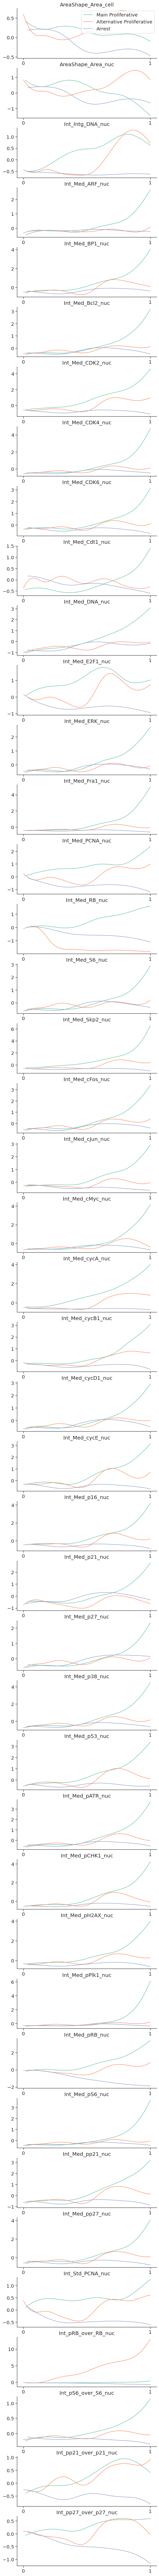

In [36]:
palantir.plot.plot_gene_trends(ps_adata, genes= genes)

findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

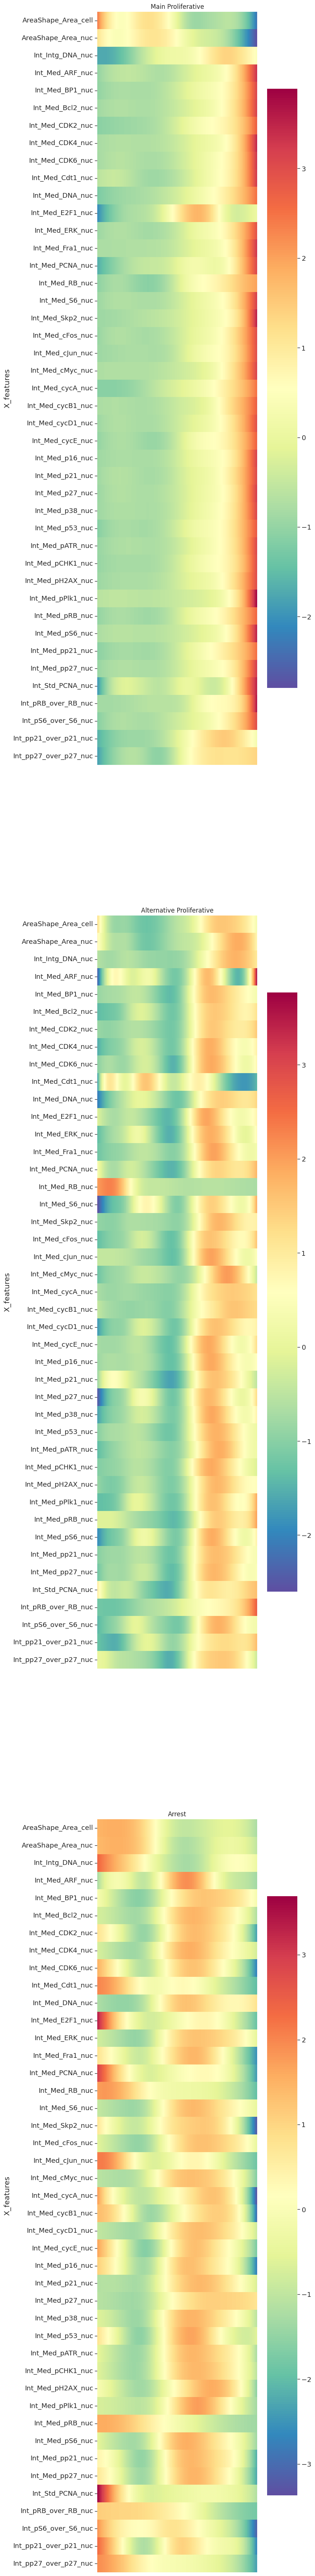

findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

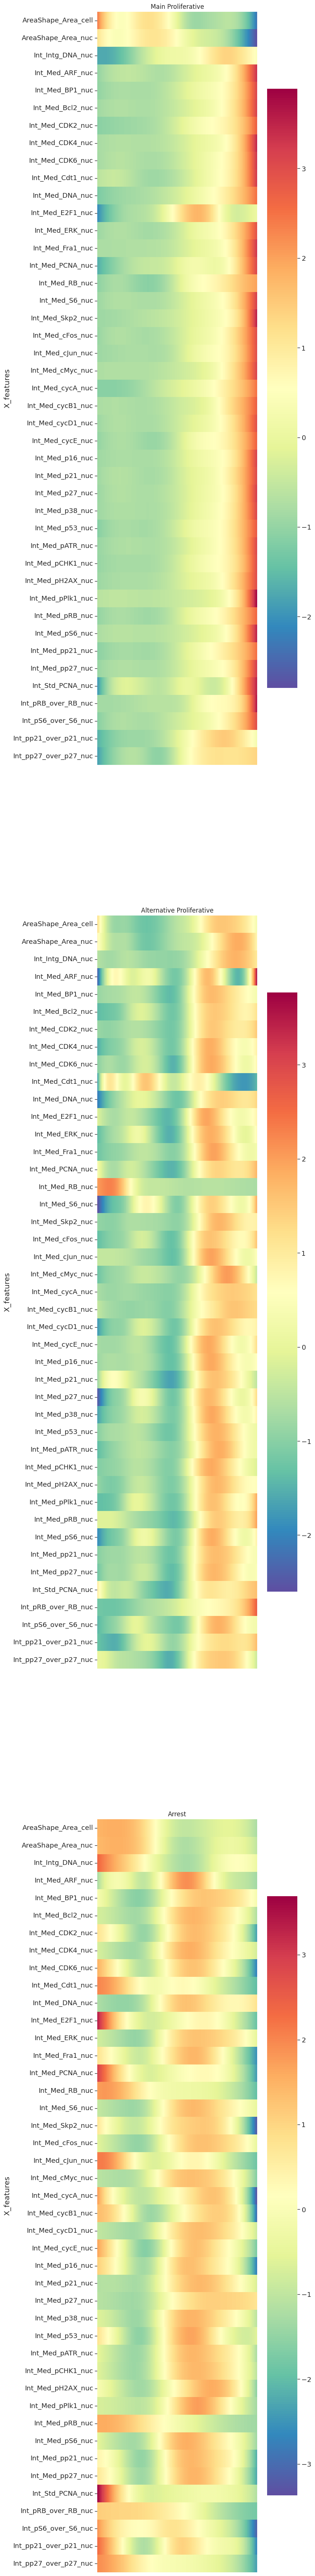

In [38]:
palantir.plot.plot_gene_trend_heatmaps(ps_adata, genes= genes)

In [ ]:
np.argwhere(ps_adata.obsm['branch_masks'].iloc[:,0].values == True).squeeze()

In [ ]:
ps_adata.obs['palantir_pseudotime']

In [ ]:
np.sum(np.sum(ps_adata.obsm['branch_masks'],axis=1).astype(bool))

In [ ]:
ps_adata.obsm['palantir_fate_probabilities']

In [ ]:
adata